In [1]:
import numpy as np 
import matplotlib.pyplot as plt
pi = np.pi
import copy
import scipy.linalg as scilinalg
from tqdm.notebook import tqdm
from scipy.integrate import quad
from numba import jit
import timeit
I = 1j

In [2]:
def round_matrix(mat): #function which rounds any matrix element with abs value <1e-12 to zero
    mat_rounded = copy.deepcopy(mat)
    for i in range(len(mat_rounded)):
        for j in range(len(mat_rounded[i])):
            if np.abs(np.real(mat_rounded[i,j]))  <1e-12:
                mat_rounded[i,j] = complex(0 , np.imag(mat_rounded[i,j]))

            if np.abs(np.imag(mat_rounded[i,j]))<1e-12:
                mat_rounded[i,j] = complex(np.real(mat_rounded[i,j]) , 0)

                
    
    return mat_rounded

############################################################################################################################################

def forward_difference(y , dx): #function for numerical differentiation using the forward difference formula
    if len(y) == 1:
        return 0
    dydx = np.array(len(y)*[0.00])
    for i in range(len(y)-1):
        dydx[i] = (y[i+1] - y[i])/(dx)
    
    dydx[-1] = (y[-1] - y[-2])/(dx)
    
    return dydx
        
##########################################################################################################################################    

def disc_pieces(x , y): #function to take a discontinuous piecewise function and return each of its pieces along with the size of each discontinuous jump 
    dy = np.array(len(y)*[0.00])
    num_discs = 0 #number of jumps
    size_jump = np.array([])  #size of the jump
    index_jump = np.array([] , dtype = int) #index AFTER which jump occurs
    
    for i in range(len(y)-1):
        dy[i] = (y[i+1] - y[i])
        
        if abs(dy[i]) >= np.pi:   #definining minimum size of a jump as pi
            #print("jump spotted")
            num_discs = num_discs + 1
            size_jump = np.append(size_jump , dy[i])
            #print(size_jump)
            index_jump = np.append(index_jump , i)
        
    
            
    #print(num_discs)
    function_subsets = (num_discs + 1)*[0.00]  #each element of this list will have a piece of the piecewise input function
    #print(len(function_subsets))
    #print(index_jump)
    
    if num_discs == 0:
        return y , 0
    
    starting_index = 0
    
    for i in range(len(function_subsets)-1):
        function_subsets[i] = y[starting_index:index_jump[i]+1]
        starting_index = index_jump[i]+1
    function_subsets[-1] = y[starting_index:]

    
    return function_subsets , size_jump
        
############################################################################################################################################
def nearest_multiple_of_pi(phase): #function to find the nearest multiple of pi
    if phase>=0:
        return (phase//pi)*pi
    else:
        return ((phase//pi)+1)*pi
    
############################################################################################################################################
    
def make_periodic(phase): #function to make the phase periodic
    if nearest_multiple_of_pi(phase) >= 0:
        if (nearest_multiple_of_pi(phase)/pi)%2 == 0:
            return (phase - nearest_multiple_of_pi(phase))
        else:
            return -(pi - (phase - nearest_multiple_of_pi(phase)))
    else:
        if (nearest_multiple_of_pi(phase)/pi)%2 == 0:
            return (phase - nearest_multiple_of_pi(phase))
        else:
            return (pi + (phase - nearest_multiple_of_pi(phase)))
        


In [8]:
class DPT:
    def __init__(self , vi , wi , vf , wf , gamma):
        self.vi = vi
        self.wi = wi
        self.vf = vf 
        self.wf = wf
        self.gamma = gamma
        self.initial_params = (self.vi , self.wi , 0)
        self.final_params = (self.vf , self.wf , self.gamma)
        # self.k = k
        # self.t = t

    def set_params_with_deltas(self , delta_i , delta_f):
        self.vi = 1 - delta_i
        self.wi = 1 + delta_i

        self.vf = 1 - delta_f
        self.wf = 1 + delta_f

    def Hi(self , k): #function to generate the 2x2 SSH Hamiltonian H(k) with given v,w,gamma for a given value of k
     
        mat = np.zeros((2,2) , dtype = complex)
        mat[0,1] = self.vi + self.wi*np.exp(I*k)
        mat[1,0] = self.vi + self.wi*np.exp(-I*k)

        return mat
    
    def Hf(self , k): #function to generate the 2x2 SSH Hamiltonian H(k) with given v,w,gamma for a given value of k
     
        mat = np.zeros((2,2) , dtype = complex)
        mat[0,1] = self.vf + self.wf*np.exp(I*k)
        mat[1,0] = self.vf + self.wf*np.exp(self.gamma - I*k)

        return mat
    

    
    def biorth_VU(self , k , dagger = False):

        if dagger:
            eigs , vl , vr = scilinalg.eig(  np.matrix.getH(self.Hf(k)) , left = True , right = True  ) #get the eigenvalues and left & right eigenvectors

        else:
            eigs , vl , vr = scilinalg.eig(  self.Hf(k) , left = True , right = True  ) #get the eigenvalues and left & right eigenvectors



        left_evec_plus = vl[:,0] #important note: scipy returns the left evecs as bra vectors! I deal with that below
        left_evec_minus = vl[:,1]
        right_evec_plus = vr[:,0]
        right_evec_minus = vr[:,1]

        #I'm using the biorthogonal normalization condition described in the Brody paper.
        #Needed to conjugate the normalization factor here for the left-evecs because right now they are bras but in all
        #inner products they will be kets and therefore will be conjugated once again
        left_evec_plus_normed = np.conjugate(1/np.sqrt(np.vdot(left_evec_plus , right_evec_plus))) * left_evec_plus 
        left_evec_minus_normed = np.conjugate(1/np.sqrt(np.vdot(left_evec_minus ,right_evec_minus))) * left_evec_minus
        
        right_evec_plus_normed = (1/np.sqrt(np.vdot(left_evec_plus , right_evec_plus))) * right_evec_plus
        right_evec_minus_normed = (1/np.sqrt(np.vdot(left_evec_minus , right_evec_minus))) * right_evec_minus

        
        #Now to define the basis transformation matrices U and V. These are matricies whose product is unity and they also diagonalize 
        #the hamiltonian.
        #U = has the two right eigenkets of the hamiltonian as its columns
        #V = has the two left eigenbras of the hamiltonian as its rows
        columnV = np.zeros((2,2) , dtype = complex)
        newU = np.zeros((2,2) , dtype = complex)

        
        #remember, left_evec_plus_normed is still a ket vector, so i'll define the matrix comumnV whose columns 
        #are these ket vectors and then take its hermitian conjugate.
        columnV[:,0] = left_evec_plus_normed 
        columnV[:,1] = left_evec_minus_normed

        #taking hermitian conjugate of the columnV matrix now gets us the V matrix. 
        #newV is a matrix with the left eigenbras of the hamiltonian as its rows
        newV = np.matrix.getH(columnV) 

        newU[:,0] = right_evec_plus_normed #newU is a matrix with the right eigenkets of the hamiltonian as its columns
        newU[:,1] = right_evec_minus_normed

        return (eigs , newV , newU)


    def Gk(self , t , k ): #function to give the Gk value (term inside the  product in the Loschmidt Echo expression)
        
        kappa_i_pm , right_vecs_initial_mat = scilinalg.eig(  self.Hi(k) , left = False , right = True  ) #get eigenvectors of initial Hamiltonian

        right_eigenket_initial_minus = right_vecs_initial_mat[:,np.where(kappa_i_pm < 0)[0]] #the eigenvector corresponding to the negative eigenvalue
  
        left_eigenbra_initial_minus = np.transpose(np.conjugate(right_eigenket_initial_minus)) #the corresponding ket vector
  
        
        kappa_f_pm , Vf , Uf = self.biorth_VU(k)
        Hf = self.Hf(k)


        #left_eigenbra_initial_plus_in_Hf_eigenbasis = left_eigenbra_initial_plus@Uf
        left_eigenbra_initial_minus_in_Hf_eigenbasis = left_eigenbra_initial_minus@Uf

        #right_eigenket_initial_plus_in_Hf_eigenbasis = Vf@right_eigenket_initial_plus
        right_eigenket_initial_minus_in_Hf_eigenbasis = Vf@right_eigenket_initial_minus

        exp_Hf = np.zeros((2,2) , dtype = complex)
        exp_Hf[0,0] = np.exp(-I*t*kappa_f_pm[0])
        exp_Hf[1,1] = np.exp(-I*t*kappa_f_pm[1])

        HfDagger = np.matrix.getH(Hf)
        HfDagger_in_Hf_eigenbasis = Vf @ HfDagger @ Uf
        exp_HfDagger_in_Hf_eigenbasis = scilinalg.expm(I*t*HfDagger_in_Hf_eigenbasis)

        norm_term = np.sqrt( left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_HfDagger_in_Hf_eigenbasis @ exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis )


        #Gkk_right = exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis

        Gkk = (left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis)/norm_term

        return Gkk
    
    def return_rate(self , t_array , k_array):
        def return_rate_integrand_for_quad(k , t):
            return (-1/(2*pi))*np.log( np.abs(self.Gk(t , k)) )
        
        limit_rate_using_quad = np.zeros(len(t_array))

        for i in tqdm(range(len(t_array))):
            limit_rate_using_quad[i] = quad(return_rate_integrand_for_quad , -pi , pi , args = (t_array[i]))[0]

        self.limit_rate = limit_rate_using_quad
        
        return limit_rate_using_quad

    
    def get_Gk_array(self , t_array , k_array):

        Gk_array = np.zeros((len(t_array) , len(k_array)) , dtype = complex)

        for i in tqdm(range(len(t_array))):
            for j in range(len(k_array)):
                Gk_array[i,j] = self.Gk(t_array[i] , k_array[j])

        self.Gk_array = Gk_array

        return Gk_array
    
    def return_rate_using_Gk_array(self, t_array , k_array):
        limit_rate_using_trapz = -(1/(2*pi))*np.trapz(np.log(np.abs(self.Gk_array)) , k_array , axis=1)
        return limit_rate_using_trapz
    

    def phi_dyn(self , t , k):
        
        def dphi_dyn(t , k):

            kappa_i_pm , right_vecs_initial_mat = scilinalg.eig(  self.Hi(k) , left = False , right = True  ) #get eigenvectors of initial Hamiltonian

            right_eigenket_initial_minus = right_vecs_initial_mat[:,np.where(kappa_i_pm < 0)[0]] #the eigenvector corresponding to the negative eigenvalue
    
            left_eigenbra_initial_minus = np.transpose(np.conjugate(right_eigenket_initial_minus)) #the corresponding ket vector
            
            kappa_f_pm , Vf , Uf = self.biorth_VU(k)
            Hf = self.Hf(k)

            #kappa_f_pm_Hdagger , Uf_Hdagger , Vf_Hdagger = self.biorth_VU(k , dagger = True)


            #left_eigenbra_initial_plus_in_Hf_eigenbasis = left_eigenbra_initial_plus@Uf
            left_eigenbra_initial_minus_in_Hf_eigenbasis = left_eigenbra_initial_minus@Uf

            #right_eigenket_initial_plus_in_Hf_eigenbasis = Vf@right_eigenket_initial_plus
            right_eigenket_initial_minus_in_Hf_eigenbasis = Vf@right_eigenket_initial_minus


            Hf_diagonal = np.zeros((2,2) , dtype = complex)
            Hf_diagonal[0,0] = kappa_f_pm[0]
            Hf_diagonal[1,1] = kappa_f_pm[1]

            exp_Hf_diagonal = np.zeros((2,2) , dtype = complex)
            exp_Hf_diagonal[0,0] = np.exp(-I*t*kappa_f_pm[0])
            exp_Hf_diagonal[1,1] = np.exp(-I*t*kappa_f_pm[1])

            HfDagger = np.matrix.getH(Hf)
            HfDagger_in_Hf_eigenbasis = Vf @ HfDagger @ Uf
            exp_HfDagger_in_Hf_eigenbasis = scilinalg.expm(I*t*HfDagger_in_Hf_eigenbasis)

            norm_term = np.sqrt( left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_HfDagger_in_Hf_eigenbasis @ exp_Hf_diagonal @ right_eigenket_initial_minus_in_Hf_eigenbasis )

            right_term = ( exp_Hf_diagonal @ right_eigenket_initial_minus_in_Hf_eigenbasis ) / norm_term

            left_term = ( left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_HfDagger_in_Hf_eigenbasis )/ norm_term

            dphi_dyn = -np.real(left_term @ Hf_diagonal @ right_term)

            return dphi_dyn
        
        phi_dyn = quad(dphi_dyn , 0 , t , args = (k))

        return phi_dyn

        # norm_term_right_in_Hf_eigenbasis = exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis
        # norm_term_left_in_HfDagger_eigenbasis = left_eigenbra_initial_minus_in_Hfdagger_eigenbasis @ exp_HfDagger

        return dphi_dyn
    
    def PGP(self , t , k):
        phi_LE = -I*np.log( self.Gk(t , k) / np.abs(self.Gk(t , k)) )
        phi_dyn = self.phi_dyn(t , k)

        if np.imag(phi_LE) > 1e-10 or np.imag(phi_dyn) > 1e-10:
            raise Exception("Phases must be real, but here they are complex!")
        
        else:

            PGP = make_periodic(  make_periodic(np.real(phi_LE)) - make_periodic(np.real(phi_dyn))  )

        return PGP
    
    def get_PGP_array(self , t_array , k_array):

        PGP_array = np.zeros((len(t_array) , len(k_array)))
        
        for i in tqdm(range(len(t_array))):
            for j in range(len(k_array)):
                PGP_array[i,j] = self.PGP(t_array[i] , k_array[j])
        
        self.PGP_array = PGP_array
        
        return PGP_array
    




In [6]:
t_array = np.linspace(0,30,500)
k_array = np.linspace(-pi , pi , 501)

In [4]:
T_to_NT = DPT(0,0,0,0,0.4)
T_to_NT.set_params_with_deltas(-0.9 , 0.9)

In [6]:
T_to_NT.vi , T_to_NT.wi

(1.9, 0.09999999999999998)

In [7]:
T_to_NT.Gk(1 , pi/3)

array([[-0.64847948+0.44032533j]])

In [8]:
t_array = np.linspace(0,30,500)
k_array = np.linspace(-pi , pi , 501)

rate = T_to_NT.return_rate(t_array , k_array)

  0%|          | 0/500 [00:00<?, ?it/s]

(0.0, 8.0)

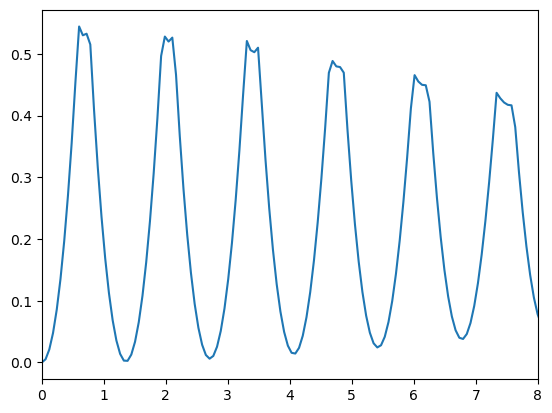

In [9]:
plt.plot(t_array , rate)
plt.xlim(0,8)


In [10]:
T_to_NT.get_Gk_array(t_array , k_array)

  0%|          | 0/500 [00:00<?, ?it/s]

array([[ 1.        -6.16297582e-33j,  1.        -1.62630326e-19j,
         1.        -1.35525272e-18j, ...,  1.        +2.16840434e-18j,
         1.        -1.59919820e-18j,  1.        +6.16297582e-33j],
       [ 0.99034145-1.35796346e-01j,  0.99033403-1.35835903e-01j,
         0.9903266 -1.35850532e-01j, ...,  0.99035628-1.35642591e-01j,
         0.99034887-1.35731895e-01j,  0.99034145-1.35796346e-01j],
       [ 0.96167024-2.68564989e-01j,  0.96161276-2.68738043e-01j,
         0.96155515-2.68861991e-01j, ...,  0.96178479-2.68072110e-01j,
         0.96172759-2.68342963e-01j,  0.96167024-2.68564989e-01j],
       ...,
       [-0.94617015+3.17008076e-01j, -0.94604891+3.17422398e-01j,
        -0.94574338+3.18298825e-01j, ..., -0.9458625 +3.17550544e-01j,
        -0.94610802+3.17052368e-01j, -0.94617015+3.17008076e-01j],
       [-0.89289725+4.40993501e-01j, -0.89263691+4.41595213e-01j,
        -0.8921258 +4.42598125e-01j, ..., -0.89267222+4.40971691e-01j,
        -0.89290865+4.40787832e-01j

In [11]:
rt = T_to_NT.return_rate_using_Gk_array(t_array , k_array)

(0.0, 8.0)

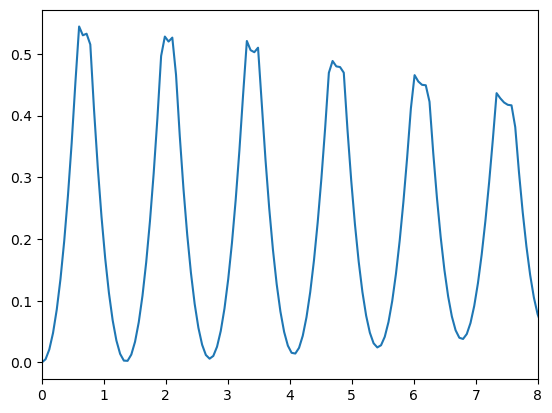

In [12]:
plt.plot(t_array , rt)
plt.xlim(0,8)

In [7]:
T_to_NT.get_PGP_array(t_array , k_array)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 